In [45]:
from typing import List, Tuple
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import openfermion as of
import cirq
import qiskit
from qiskit.qasm2 import dumps
from cirq.contrib.qasm_import import circuit_from_qasm
from convert import cirq_pauli_sum_to_qiskit_pauli_op

In [46]:
# See Kirby paper
def upper_bound(H_norm, overlap, d, delta, delta_prime, Delta_prime, chi, zeta):
    term0 = delta_prime if delta_prime > Delta_prime else 0
    term1 = (1/overlap)*(1+6*H_norm/(delta_prime-delta))*chi
    term2 = (6*H_norm/overlap)*zeta
    term3 = (6*H_norm/overlap)*8*(1+0.5*np.pi*delta/H_norm)**(-2*d)
    out = term0+term1+term2+term3
    return out

In [47]:
def minimized_bound(H_norm, overlap_prime, d, Delta, Delta_prime, chi, zeta):
    def upper_bound_fn(x):
            return upper_bound(H_norm, overlap_prime, d, x[0], x[1], Delta_prime, chi, zeta)
        
    if Delta_prime > 0:
        x0 = (Delta_prime/2, Delta_prime)
    else:
        x0 = (Delta/2,Delta)
    
    
    # Minimize over values of delta and delta_prime:
    min_bound = sp.optimize.minimize(
        upper_bound_fn,
        method='COBYLA',
        x0=x0,
        constraints=(
            {'type': 'ineq', 'fun': lambda x:  x[1]-x[0]-chi/overlap_prime},
            {'type': 'ineq', 'fun': lambda x:  x[0]},
            {'type': 'ineq', 'fun': lambda x:  x[1]},
            {'type': 'ineq', 'fun': lambda x:  (Delta_prime-0.01 if Delta_prime>0.01 else Delta) - x[1]}
        )
    )
    
    if min_bound.fun < upper_bound_fn(x0):
        bound = min_bound.fun
    else:
        print('Minimization failed bound', min_bound.fun, 'replaced with default (initial) point')
        bound = upper_bound_fn(x0)
    return bound

In [48]:
def fill_h_and_s_matrices(
    vectors: List[np.ndarray],
    matrix: np.ndarray,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    dim = len(vectors)
    h = np.zeros((dim, dim), dtype=np.complex128)
    s = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(dim):
        for j in range(i, dim):
            if verbose:
                print(i, j)
            hij = vectors[i].conj().T @ matrix @ vectors[j]
            h[i, j] = hij

            if i != j:
                h[j, i] = np.conjugate(hij)

            sij = vectors[i].conj().T @ vectors[j]
            s[i, j] = sij
            if i != j:
                s[j, i] = np.conjugate(sij)
    return h, s

In [49]:
# Based on https://quantum.cloud.ibm.com/docs/en/tutorials/krylov-quantum-diagonalization.
# and Algorithm 1.1 of https://arxiv.org/abs/2110.07492.
def solve_regularized_gen_eig(
    h: np.ndarray,
    s: np.ndarray,
    threshold: float,
) -> float:
    if np.isclose(threshold, 0, atol=1e-10):
        h_reg = h
        s_reg = s
    else:
        s_vals, s_vecs = sp.linalg.eigh(s)
        s_vecs = s_vecs.T
        good_vecs = np.array(
            [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
        )
        h_reg = good_vecs.conj() @ h @ good_vecs.T
        s_reg = good_vecs.conj() @ s @ good_vecs.T
        return sp.linalg.eigh(h_reg, s_reg)[0][0]

In [50]:
l = 2
t = 1.0
u = 4.0
hamiltonian_fermi = of.hamiltonians.fermi_hubbard(
    l, l, t, u, spinless=True, periodic=False
)
hamiltonian = of.transforms.jordan_wigner(hamiltonian_fermi)
nqubits = of.utils.count_qubits(hamiltonian)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(hamiltonian)
ham_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(ham_cirq)
matrix = ham_cirq.matrix()
ham_norm = np.linalg.norm(matrix)

evals_exact, evecs_exact = np.linalg.eigh(matrix)
ground_state = evecs_exact.T[0]
energy_exact = min(evals_exact)
print("Exact energy:", energy_exact)

sorted_evals_exact = sorted(evals_exact)
excited_energy = sorted_evals_exact[1]
print("Excited state energy =", excited_energy)
big_delta = excited_energy - energy_exact
print("Delta =", big_delta)

bvec = ground_state + np.random.randn(ground_state.shape[0]) / 5.0
bvec /= np.linalg.norm(bvec)

overlap = np.abs(bvec.conj().T @ ground_state) ** 2
print("Overlap =", overlap)

Exact energy: -2.0
Excited state energy = -0.8284271247461893
Delta = 1.1715728752538106
Overlap = 0.6513817228713096


## Error vs. $d$ with perfect Trotter.

If we implement Trotter prefectly, then $||H'-H|| = 0$ and $||S'-S||=0$, which means $\chi = 0$. Since $||S' - S|| = 0$, $\zeta = 2 d \epsilon$. Since $\chi = 0$, $\Delta' = \Delta$.

In [51]:
eps = 1e-8
ds = [1, 2, 5, 10, 20, 30, 50]

upper_bounds = []
for d in ds:
    zeta = 2 * d * eps
    bound = minimized_bound(ham_norm, overlap, d, big_delta, big_delta, 0., zeta)
    upper_bounds.append(bound)

/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_79552/509866375.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  term1 = (1/overlap)*(1+6*H_norm/(delta_prime-delta))*chi
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_79552/509866375.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  term1 = (1/overlap)*(1+6*H_norm/(delta_prime-delta))*chi


Text(0, 0.5, 'Upper bound on $|E - E_0|$')

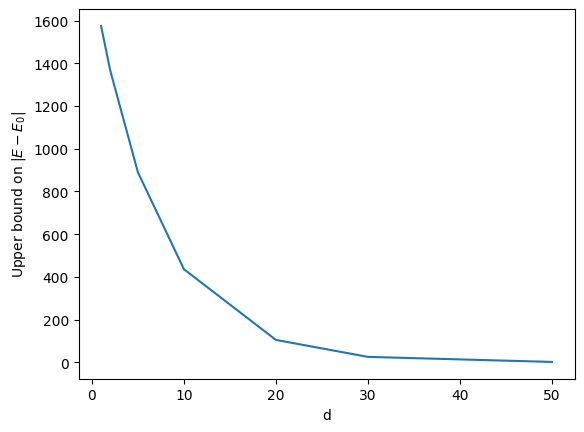

In [52]:
fig, ax = plt.subplots()
plt.plot(ds, upper_bounds)
ax.set_xlabel("d")
ax.set_ylabel(r"Upper bound on $|E - E_0|$")

## Error vs. number of Trotter steps

In [53]:
subspace_dimension = 10
threshold = 1e-4

In [54]:
dt = np.pi / (evals_exact[-1] - evals_exact[0])

vectors_u = []
for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
    print(k)
    Uk = sp.linalg.expm(-1j * matrix * k * dt)
    vectors_u.append(Uk @ bvec)

-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/linalg/_matfuncs.py:373: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


In [55]:
h_u, s_u = fill_h_and_s_matrices(vectors_u, matrix)

In [56]:
krylov_u_evals = []
for d in range(1, len(h_u)):
    krylov_energy = solve_regularized_gen_eig(h_u[:d, :d], s_u[:d, :d], threshold=threshold)
    print(krylov_energy)
    krylov_u_evals.append(krylov_energy)

-0.4543234239427999
-1.6621900567604477
-1.8614140779888673
-1.9509060976978123
-1.9473741690614692
-1.979087884083527
-1.9784827640761997
-1.9932720090037226
-1.9928199579481394
-1.9915042455103997
-1.9974592396156046
-1.996677919682928
-1.999462544928694
-1.9992651401585366
-1.9990095949343731
-1.998506576817123
-1.9999992565206626
-1.9999933662360758
-1.999993661568389
-1.999999225735315
-1.999999684972544
-1.9999991748533947
-1.9999999131346577
-1.9999998669051133
-1.9999999269362396
-1.9999999540951519
-1.9999999620184654
-1.9999999541738187
-1.99999994321041
-1.999999988608662
-1.9999999638548676
-1.9999999945541234
-1.9999999769956924
-1.9999999936311974
-1.9999999721696446
-1.9999999998340798
-1.9999999897060063
-1.9999999979691803
-1.9999999890491529
-1.9999999968397848


/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_79552/215692311.py:17: RuntimeWarning: divide by zero encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_79552/215692311.py:17: RuntimeWarning: overflow encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_79552/215692311.py:17: RuntimeWarning: invalid value encountered in matmul
  h_reg = good_vecs.conj() @ h @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_79552/215692311.py:18: RuntimeWarning: divide by zero encountered in matmul
  s_reg = good_vecs.conj() @ s @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_79552/215692311.py:18: RuntimeWarning: overflow encountered in matmul
  s_reg = good_vecs.conj() @ s @ good_vecs.T
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_79552/215692311.py:18: RuntimeWarning: invalid value e

## Get subspace matrices with Trotter.

In [57]:
ntrotter_values = [1, 2, 4, 8, 16, 32, 100]
ngates_twoq = []
ngates_oneq = []
depths = []
all_krylov_u_trotter_evals = []
all_trotter_h = []
all_trotter_s = []

for ntrotter in ntrotter_values:
    print("On ntrotter =", ntrotter)
    trotter_operation = qiskit.circuit.library.PauliEvolutionGate(
        ham_qiskit,
        time=dt,
        synthesis=qiskit.synthesis.LieTrotter(reps=ntrotter)
    )

    # trotter_circuit = qiskit.QuantumCircuit.from_instructions(
    #     [[trotter_operation]],
    #     qubits=qiskit.QuantumRegister(trotter_operation.num_qubits),
    # )
    trotter_circuit = qiskit.QuantumCircuit(nqubits)
    trotter_circuit.append(trotter_operation, trotter_circuit.qubits)
    trotter_circuit = qiskit.transpile(
        trotter_circuit, basis_gates=["u3", "cx"]
    )  # TODO: Compile to a target backend, e.g. IBM Fez.
    opcounts = trotter_circuit.count_ops()
    ngates_twoq.append(opcounts.get("cx"))
    ngates_oneq.append(opcounts.get("u3"))
    depths.append(trotter_circuit.depth())

    # qasm = dumps(trotter_circuit)
    # trotter_circuit_cirq = circuit_from_qasm(qasm.replace("qregless", "q"))

    # qubits = sorted(trotter_circuit_cirq.all_qubits())
    # Utrotter = cirq.unitary(trotter_circuit_cirq)
    Utrotter = qiskit.quantum_info.Operator(trotter_circuit)

    vectors_u_trotter = []
    for k in range(-2 * subspace_dimension, 2 * subspace_dimension + 1, 1):
        # print(k)
        Uk = np.linalg.matrix_power(Utrotter, k)
        vectors_u_trotter.append(Uk @ bvec)
    
    h, s = fill_h_and_s_matrices(vectors_u_trotter, matrix)

    # TODO This error does not get smaller with more Trotter steps. Issue with circuit conversion or something else?
    h_norm_err = sp.linalg.norm(h - h_u)
    s_norm_err = sp.linalg.norm(s - s_u)
    print("H norm err per element:", h_norm_err / h.shape[0] ** 2)
    print("S norm err per element:", s_norm_err / s.shape[0] ** 2)

    krylov_u_trotter_evals = []
    for d in range(1, len(h)):
        krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
        krylov_u_trotter_evals.append(krylov_energy)
    
    all_krylov_u_trotter_evals.append(krylov_u_trotter_evals)
    all_trotter_h.append(h.copy())
    all_trotter_s.append(s.copy())

On ntrotter = 1
H norm err per element: 0.005510173641286867
S norm err per element: 0.0009504075984570517
On ntrotter = 2
H norm err per element: 0.0016610420295208154
S norm err per element: 0.0002618377143499247
On ntrotter = 4
H norm err per element: 0.000523476327312177
S norm err per element: 6.708338675495678e-05
On ntrotter = 8
H norm err per element: 0.00020093541138114897
S norm err per element: 1.6874089888240566e-05
On ntrotter = 16
H norm err per element: 9.110574656469136e-05
S norm err per element: 4.225002601029749e-06
On ntrotter = 32


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: divide by zero encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: overflow encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: invalid value encountered in matmul
  z = a if z is None else fmatmul(z, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:680: RuntimeWarning: divide by zero encountered in matmul
  result = z if result is None else fmatmul(result, z)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/linalg/linalg.py:680: RuntimeWarning: overflow encountered in matmul
  result = z if result is None else fmatmul(result, z)
/Users/benjamindalfavero/.venv/compare

H norm err per element: 4.4299124479094605e-05
S norm err per element: 1.0566560034763363e-06
On ntrotter = 100
H norm err per element: 1.4053296460218366e-05
S norm err per element: 1.0821397475361464e-07


In [58]:
all_h_distances = []
all_s_distances = []
all_chis = []
all_overlap_primes = []
all_delta_primes = []
all_zetas = []
for h, s in zip(all_trotter_h, all_trotter_s):
    h_dist = sp.linalg.norm(h_u - h, ord=2)
    all_h_distances.append(h_dist)
    s_dist = sp.linalg.norm(s_u - s, ord=2)
    all_s_distances.append(s_dist)

    print("H maximum:", np.max(np.abs(h_u - h)))
    print("H minimum:", np.min(np.abs(h_u - h)))
    print("S maximum:", np.max(np.abs(s_u - s)))
    print("S minimum:", np.min(np.abs(s_u - s)))

    chi = h_dist + ham_norm * s_dist
    all_chis.append(chi)
    overlap_prime = overlap - 2 * threshold - 2 * s_dist
    all_overlap_primes.append(overlap_prime)
    delta_prime = big_delta - chi / overlap_prime
    all_delta_primes.append(delta_prime)
    zeta = 2 * subspace_dimension * (threshold + s_dist)
    all_zetas.append(zeta)

H maximum: 0.47236580549211016
H minimum: 0.0
S maximum: 0.0818438474852743
S minimum: 0.0
H maximum: 0.15474732382467918
H minimum: 0.0
S maximum: 0.022006641841171945
S minimum: 0.0
H maximum: 0.05272331330164051
H minimum: 0.0
S maximum: 0.005600976359724207
S minimum: 0.0
H maximum: 0.020393869086497495
H minimum: 0.0
S maximum: 0.0014064944432220397
S minimum: 0.0
H maximum: 0.00935707215913567
H minimum: 0.0
S maximum: 0.00035201492991044676
S minimum: 0.0
H maximum: 0.004519039926946694
H minimum: 0.0
S maximum: 8.802815641911684e-05
S minimum: 0.0
H maximum: 0.0014186044792029783
H minimum: 0.0
S maximum: 9.014808141694347e-06
S minimum: 0.0


In [59]:
all_bounds = []
for i in range(len(all_h_distances)):
    overlap_prime = all_overlap_primes[i]
    delta_prime = all_delta_primes[i]
    chi = all_chis[i]
    zeta = all_zetas[i]
    bound = minimized_bound(ham_norm, overlap_prime, subspace_dimension, big_delta, delta_prime, chi, zeta)
    all_bounds.append(bound)
    print(bound)

-18268749.9673641
Minimization failed bound 1.8129708911128463e+79 replaced with default (initial) point
20891.789138961103
Minimization failed bound 8518.85571705502 replaced with default (initial) point
2471.4197506181868
2902.558758578712
1037.586877601668
688.8256529378145
534.458735601529


In [60]:
print(len(all_bounds))

7


In [61]:
# Convert all Trotterized eigenvalues into a dataframe.
dfs = []
for evals, ntrotter in zip(all_krylov_u_trotter_evals, ntrotter_values):
    errs = np.abs(evals - energy_exact)
    df = pd.DataFrame({"d": range(len(evals)), "energy": evals, "error": errs})
    df["ntrotter"] = ntrotter
    dfs.append(df)
big_df = pd.concat(dfs)
print(big_df.head())

   d    energy     error  ntrotter
0  0 -0.510422  1.489578         1
1  1 -1.694384  0.305616         1
2  2 -1.854500  0.145500         1
3  3 -1.930061  0.069939         1
4  4 -1.924844  0.075156         1


In [62]:
krylov_u_errors = np.abs(krylov_u_evals - energy_exact)
min_error_u = np.min(krylov_u_errors)
print(f"Min error for exact U:", min_error_u)

Min error for exact U: 1.6592016649497054e-10


In [63]:
d_vals = np.unique(big_df["d"])
selected_d_vals = [5, 10, 15, 20, 25, 30]
assert set(selected_d_vals).issubset(set(d_vals))

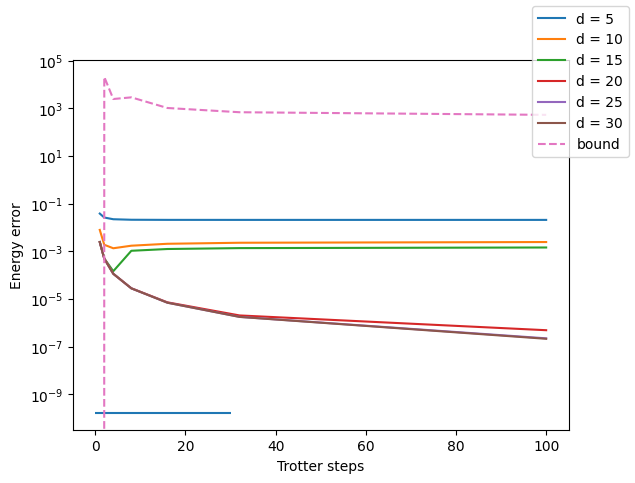

In [64]:
fig, ax = plt.subplots()

for d in selected_d_vals:
    df_d = big_df[big_df["d"] == d]
    ax.plot(df_d["ntrotter"], df_d["error"], label=f"d = {d}")

ax.hlines(np.min(krylov_u_errors), 0., max(selected_d_vals))
ax.plot(ntrotter_values, all_bounds, "--", label="bound")
ax.set_yscale("log")
ax.set_xlabel("Trotter steps")
ax.set_ylabel("Energy error")
fig.legend()

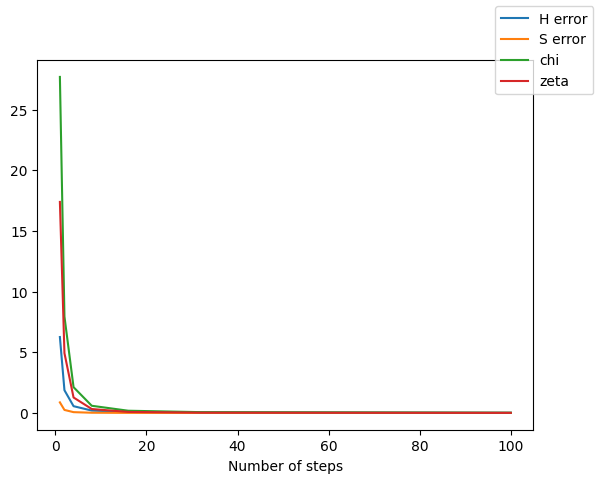

In [67]:
fig2, ax2 = plt.subplots()
ax2.plot(ntrotter_values, all_h_distances, label="H error")
ax2.plot(ntrotter_values, all_s_distances, label="S error")
ax2.plot(ntrotter_values, all_chis, label="chi")
ax2.plot(ntrotter_values, all_zetas, label="zeta")
ax2.set_xlabel("Number of steps")
fig2.legend()

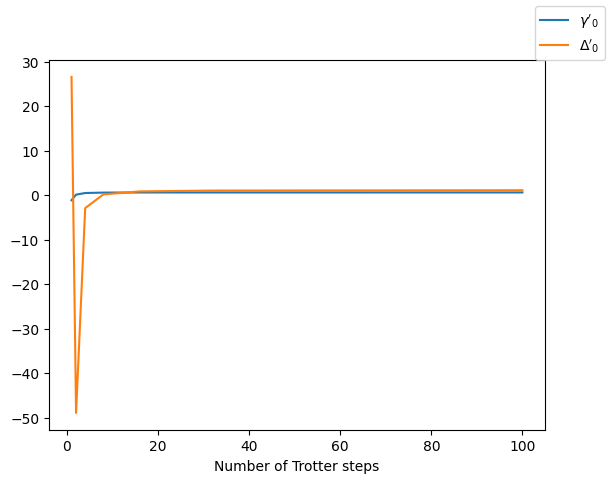

In [68]:
fig3, ax3 = plt.subplots()
ax3.plot(ntrotter_values, all_overlap_primes, label=r"$\gamma'_0$")
ax3.plot(ntrotter_values, all_delta_primes, label=r"$\Delta'_0$")
ax3.set_xlabel("Number of Trotter steps")
fig3.legend()